<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/algorithms/XGBoost/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚽ Premier League Team Performance Prediction — XGBoost


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_style("whitegrid")
pd.set_option("display.max_columns", 50)

from xgboost import XGBRegressor

## Load Data

In [ ]:
# Load dataset
candidate_paths = [
    Path('data/processed/team_season_aggregated.csv'),
    Path('../data/processed/team_season_aggregated.csv'),
    Path('../../data/processed/team_season_aggregated.csv'),
    Path('../../../data/processed/team_season_aggregated.csv'),
    Path('/content/team_season_aggregated.csv')
]
agg_path = next((p for p in candidate_paths if p.exists()), None)
if agg_path is None:
    raise FileNotFoundError('team_season_aggregated.csv not found. Run preprocessing first.')
print(f"✅ Loading dataset: {agg_path}")
df = pd.read_csv(agg_path)
print("Shape:", df.shape)
print("Seasons:", sorted(df['Season'].unique()))
print(df.head())

# Feature set (inputs)
feature_cols = [
    'Team_encoded', 'Season_encoded',
    'Wins', 'Draws', 'Losses',
    'Goals_Scored', 'Goals_Conceded', 'Goal_Difference',
    'Avg_Goals_Scored', 'Avg_Goals_Conceded',
    'Total_Shots', 'Total_Shots_On_Target', 'Avg_Shots', 'Avg_Shots_On_Target',
    'Shot_Accuracy', 'Clean_Sheets', 'Clean_Sheet_Rate',
    'Yellow_Cards', 'Red_Cards', 'Fouls', 'Corners',
    'Win_Rate', 'Home_Win_Rate', 'Away_Win_Rate', 'Points_Per_Game'
]

# Targets (performance metrics to predict)
# Adjust this list if your dataset lacks any of these columns
target_cols = [
    'Points', 'Points_Per_Game', 'Wins', 'Goals_Scored', 'Goals_Conceded', 'Goal_Difference', 'Win_Rate'
]

# Validate target availability
missing_targets = [t for t in target_cols if t not in df.columns]
if missing_targets:
    raise ValueError(f"Missing target columns in dataset: {missing_targets}")

X = df[feature_cols].copy()
print(f"Features: {len(feature_cols)} | Targets: {len(target_cols)}")

✅ Loading dataset: /content/team_season_aggregated.csv
Shape: (500, 35)
Seasons: ['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
    Season  Season_encoded        Team  Matches_Played  Home_Matches  \
0  2000-01               0  Man United              38            19   
1  2000-01               0     Arsenal              38            19   
2  2000-01               0   Liverpool              38            19   
3  2000-01               0       Leeds              38            19   
4  2000-01               0     Ipswich              38            19   

   Away_Matches  Wins  Draws  Losses  Home_Wins  Away_Wins  Points  \
0            19    24      8       6         15          9      80   
1            19    20     10       8         15          5      70   


## Train-Test Split

In [ ]:
train_mask = df['Season'] != '2024-25'
test_mask  = df['Season'] == '2024-25'

X_train = X[train_mask]
X_test  = X[test_mask]

# Build per-target y dictionaries
y_train_dict = {t: df.loc[train_mask, t].values for t in target_cols}
y_test_dict  = {t: df.loc[test_mask,  t].values for t in target_cols}

print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")

# Anchor target used for hyperparameter tuning and early stopping
anchor_target = 'Points_Per_Game' if 'Points_Per_Game' in target_cols else target_cols[0]

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_dict[anchor_target], test_size=0.15, random_state=42)
print(f"Internal train: {len(X_tr)} | Validation: {len(X_val)} | Anchor target: {anchor_target}")

Training samples: 480 | Test samples: 20
Internal train: 408 | Validation: 72 | Anchor target: Points_Per_Game


## Hyperparameter Tuning (Randomized Search)
We focus on key boosting + regularization parameters to balance performance and overfitting control.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
import time

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # fast on tabular
    booster='gbtree',
    n_estimators=1000,   # high upper bound, early stopping will truncate
    random_state=42,
    verbosity=0
)

param_distributions = {
    'learning_rate': st.uniform(0.01, 0.25),
    'max_depth': st.randint(3, 9),
    'min_child_weight': st.randint(1, 8),
    'subsample': st.uniform(0.6, 0.4),
    'colsample_bytree': st.uniform(0.6, 0.4),
    'gamma': st.uniform(0, 0.6),
    'reg_lambda': st.uniform(0.5, 2.5),
    'reg_alpha': st.uniform(0, 0.4)
}

n_iter = 40
print(f"Starting RandomizedSearchCV (n_iter={n_iter}) on anchor target: {anchor_target}...")
start = time.time()
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
search.fit(X_train, y_train_dict[anchor_target])
elapsed = time.time() - start
print(f"✅ Search complete in {elapsed/60:.1f} min")
print("Best MAE:", -search.best_score_)
print("Best Params:")
for k,v in search.best_params_.items():
    print(f"  {k}: {v}")

best_params = search.best_params_

Starting RandomizedSearchCV (n_iter=40) on anchor target: Points_Per_Game...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ Search complete in 0.8 min
Best MAE: 0.014816739442839937
Best Params:
  colsample_bytree: 0.836965827544817
  gamma: 0.027870247631998635
  learning_rate: 0.1618862129753596
  max_depth: 7
  min_child_weight: 1
  reg_alpha: 0.02602063719411181
  reg_lambda: 2.8722138431333333
  subsample: 0.9862528132298237


## Train Final Models with Early Stopping (Per Target)

In [ ]:
import xgboost
print(f"XGBoost version: {xgboost.__version__}")

xgb_models = {}
train_preds = {}
test_preds = {}

# Use the latest way to handle early stopping
from xgboost import callback as xgb_cb

for target in target_cols:
    print("\n" + "-"*80)
    print(f"Training target: {target}")

    # Create internal train-validation split for the current target
    # This ensures that each model is trained and validated on its own target's data.
    # We re-run train_test_split on the current target's y to ensure alignment with X_tr/X_val.
    _, _, y_tr_current, y_val_current = train_test_split(
        X_train, y_train_dict[target], test_size=0.15, random_state=42
    )

    model = XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        booster='gbtree',
        n_estimators=5000,
        random_state=42,
        verbosity=0,
        eval_metric='mae', # MAE is used as the early stopping metric
        **best_params
    )

    # Prepare early stopping callback
    early_stopping_callback = xgb_cb.EarlyStopping(
        rounds=75,
        save_best=True,
        maximize=False, # MAE should be minimized
        data_name="validation_0", # Refers to the first item in eval_set
        metric_name="mae"
    )

    try:
        model.fit(
            X_tr, y_tr_current, # Train on current target's data
            eval_set=[(X_val, y_val_current)], # Validate on current target's data
            callbacks=[early_stopping_callback],
            verbose=False
        )
    except Exception as e:
        print(f"Warning: Early stopping failed for target {target} due to: {e}. Retrying without early stopping.")
        # Fallback training without early stopping callback
        try:
            model.fit(
                X_tr, y_tr_current,
                eval_set=[(X_val, y_val_current)],
                verbose=False
            )
        except Exception as e_fallback:
            print(f"Warning: Fallback training failed for target {target} due to: {e_fallback}. Training without eval_set.")
            model.fit(X_tr, y_tr_current)

    # Refit on full training data for this target using best_iteration if available
    # best_iteration is 0-indexed, so add 1 for n_estimators
    n_estimators_final = getattr(model, 'best_iteration', None)
    if n_estimators_final is not None and isinstance(n_estimators_final, (int, np.integer)) and n_estimators_final >= 0:
        model_final = XGBRegressor(
            objective='reg:squarederror',
            tree_method='hist',
            booster='gbtree',
            n_estimators=int(n_estimators_final + 1),
            random_state=42,
            verbosity=0,
            eval_metric='mae',
            **best_params
        )
    else:
        print(f"Warning: best_iteration not found for {target}. Using n_estimators from best_params or default (800).")
        model_final = XGBRegressor(
            objective='reg:squarederror',
            tree_method='hist',
            booster='gbtree',
            n_estimators=best_params.get('n_estimators', 800),
            random_state=42,
            verbosity=0,
            eval_metric='mae',
            **{k:v for k,v in best_params.items() if k != 'n_estimators'} # Ensure n_estimators is not passed twice
        )
    # Refit the final model on the entire training dataset for this specific target
    model_final.fit(X_train, y_train_dict[target])

    xgb_models[target] = model_final
    train_preds[target] = model_final.predict(X_train)
    test_preds[target]  = model_final.predict(X_test)

print("\n✅ Trained models for:", ", ".join(xgb_models.keys()))

Streaming output truncated to the last 5000 lines.
[3097]	validation_0-mae:0.38142
[3098]	validation_0-mae:0.38138
[3099]	validation_0-mae:0.38138
[3100]	validation_0-mae:0.38136
[3101]	validation_0-mae:0.38136
[3102]	validation_0-mae:0.38136
[3103]	validation_0-mae:0.38136
[3104]	validation_0-mae:0.38136
[3105]	validation_0-mae:0.38136
[3106]	validation_0-mae:0.38136
[3107]	validation_0-mae:0.38136
[3108]	validation_0-mae:0.38136
[3109]	validation_0-mae:0.38135
[3110]	validation_0-mae:0.38135
[3111]	validation_0-mae:0.38137
[3112]	validation_0-mae:0.38137
[3113]	validation_0-mae:0.38136
[3114]	validation_0-mae:0.38137
[3115]	validation_0-mae:0.38135
[3116]	validation_0-mae:0.38135
[3117]	validation_0-mae:0.38136
[3118]	validation_0-mae:0.38136
[3119]	validation_0-mae:0.38135
[3120]	validation_0-mae:0.38133
[3121]	validation_0-mae:0.38135
[3122]	validation_0-mae:0.38135
[3123]	validation_0-mae:0.38136
[3124]	validation_0-mae:0.38135
[3125]	validation_0-mae:0.38134
[3126]	validation_0-m

KeyboardInterrupt: 

## Evaluation Metrics (Per Target)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rows = []
for t in target_cols:
    ytr = y_train_dict[t]
    yte = y_test_dict[t]
    ptr = train_preds[t]
    pte = test_preds[t]
    mae_tr = mean_absolute_error(ytr, ptr)
    mae_te = mean_absolute_error(yte, pte)
    rmse_tr = np.sqrt(mean_squared_error(ytr, ptr))
    rmse_te = np.sqrt(mean_squared_error(yte, pte))
    r2_tr = r2_score(ytr, ptr)
    r2_te = r2_score(yte, pte)
    rows.append([t, mae_tr, mae_te, rmse_tr, rmse_te, r2_tr, r2_te])

metrics_df = pd.DataFrame(rows, columns=[
    'Target','MAE_Train','MAE_Test','RMSE_Train','RMSE_Test','R2_Train','R2_Test'
]).sort_values('MAE_Test')

print("="*80)
print("XGBOOST TEAM PERFORMANCE — METRICS BY TARGET")
print("="*80)
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
print("="*80)

NameError: name 'target_cols' is not defined

## Feature Importance & SHAP (Anchor Target)

Top 15 features by Gain for target: Points_Per_Game
Points_Per_Game           Gain=2.64 █████████████████████████
Wins                      Gain=2.17 ████████████████████
Win_Rate                  Gain=0.10 
Losses                    Gain=0.09 
Goal_Difference           Gain=0.08 
Draws                     Gain=0.06 
Goals_Scored              Gain=0.00 
Season_encoded            Gain=0.00 
Team_encoded              Gain=0.00 
Avg_Goals_Scored          Gain=0.00 
Goals_Conceded            Gain=0.00 
Avg_Goals_Conceded        Gain=0.00 
Total_Shots               Gain=0.00 
Avg_Shots_On_Target       Gain=0.00 
Shot_Accuracy             Gain=0.00 


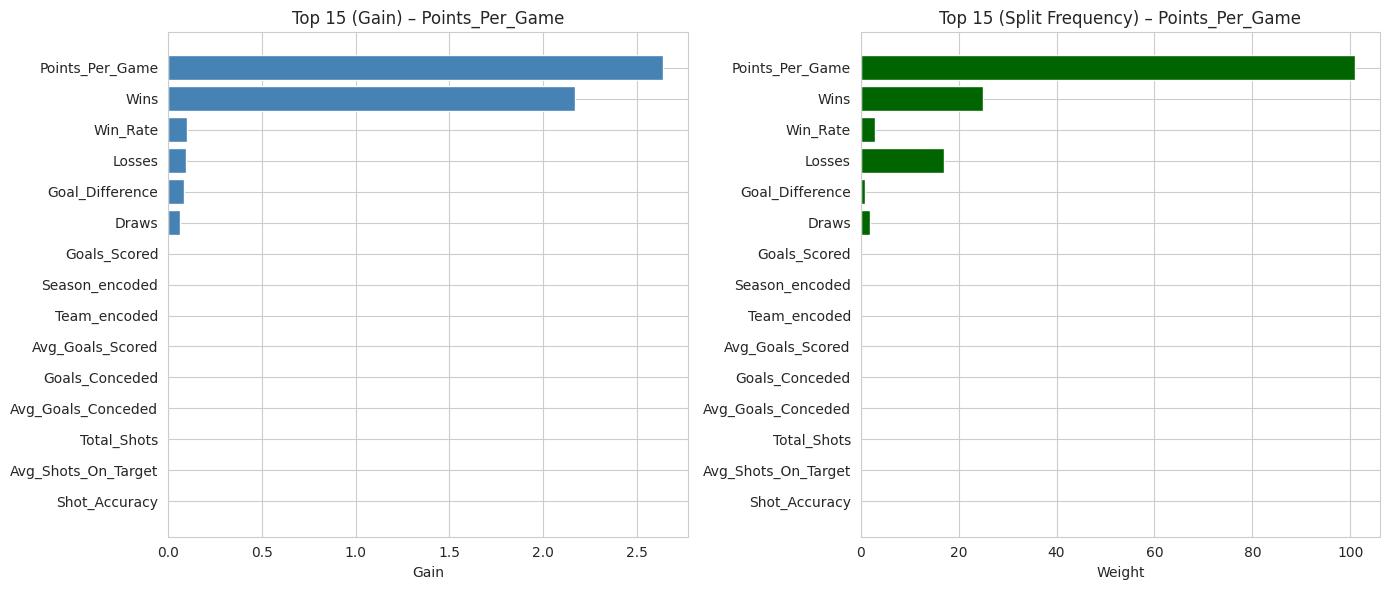

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Use anchor target model for interpretability
anchor_model = xgb_models[anchor_target]
booster = anchor_model.get_booster()
importance_gain = booster.get_score(importance_type='gain')
importance_weight = booster.get_score(importance_type='weight')

imp_df = pd.DataFrame([
    (feat, importance_gain.get(feat, 0), importance_weight.get(feat, 0))
    for feat in booster.feature_names
], columns=['Feature','Gain','Weight']).sort_values('Gain', ascending=False)

print(f"Top 15 features by Gain for target: {anchor_target}")
for _, row in imp_df.head(15).iterrows():
    bar = '█' * int((row['Gain']/max(imp_df['Gain'].max(), 1e-9))*25)
    print(f"{row['Feature']:25s} Gain={row['Gain']:.2f} {bar}")

fig, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].barh(imp_df.head(15)['Feature'], imp_df.head(15)['Gain'], color='steelblue')
axes[0].invert_yaxis(); axes[0].set_title(f'Top 15 (Gain) – {anchor_target}'); axes[0].set_xlabel('Gain')
axes[1].barh(imp_df.head(15)['Feature'], imp_df.head(15)['Weight'], color='darkgreen')
axes[1].invert_yaxis(); axes[1].set_title(f'Top 15 (Split Frequency) – {anchor_target}'); axes[1].set_xlabel('Weight')
plt.tight_layout(); plt.show()

## 2024-25 Test Season — Team Performance Predictions

In [13]:
test_df = df[df['Season'] == '2024-25'].copy()
test_df['Raw_Prediction'] = pred_test
# Lower prediction => better (closer to 1)
ranked = test_df.sort_values('Raw_Prediction').reset_index(drop=True)
ranked['Predicted_Position'] = range(1, len(ranked)+1)
ranked['Error'] = ranked['Final_Position'] - ranked['Predicted_Position']

show_cols = ['Final_Position','Predicted_Position','Error','Raw_Prediction','Team','Points','Wins','Goal_Difference']
output = ranked.sort_values('Final_Position')[show_cols].copy()
output.columns = ['Actual','Predicted','Error','RawPred','Team','Pts','W','GD']
print("="*90)
print("XGBOOST PREDICTED STANDINGS 2024-25 (Test Season)")
print("="*90)
print(output.to_string(index=False))

mae = output['Error'].abs().mean()
perfect = (output['Error']==0).sum()
within1 = (output['Error'].abs()<=1).sum()
within2 = (output['Error'].abs()<=2).sum()
print("\nSummary:")
print(f" MAE: {mae:.2f}")
print(f" Perfect: {perfect}/20")
print(f" ±1: {within1}/20 ({within1/20*100:.0f}%)")
print(f" ±2: {within2}/20 ({within2/20*100:.0f}%)")
print("="*90)

NameError: name 'pred_test' is not defined

## 2025-26 Season Forecast — Team Performance

In [ ]:

current_teams = df[df['Season'] == '2024-25']['Team'].unique()
forecast_rows = []
for team in current_teams:
    hist = df[df['Team'] == team]
    if hist.empty:
        continue
    row = {
        'Team': team,
        'Team_encoded': hist['Team_encoded'].iloc[0],
        'Season_encoded': 26  =
    }
    for col in feature_cols[2:]:
        row[col] = hist[col].mean()
    row['Seasons_Used'] = len(hist)
    forecast_rows.append(row)
forecast_features = pd.DataFrame(forecast_rows)
X_forecast = forecast_features[feature_cols]

# Predict all targets
forecast_preds = {t: xgb_models[t].predict(X_forecast) for t in target_cols}
forecast_df = pd.DataFrame({'Team': forecast_features['Team'], **forecast_preds})
forecast_df = forecast_df.sort_values('Points', ascending=False if 'Points' in forecast_df.columns else True).reset_index(drop=True)

print("PREDICTED TEAM PERFORMANCE — 2025-26")
print("="*100)
cols_to_show = ['Team'] + [t for t in ['Points','Points_Per_Game','Wins','Goals_Scored','Goals_Conceded','Goal_Difference','Win_Rate'] if t in forecast_df.columns]
print(forecast_df[cols_to_show].to_string(index=False, float_format=lambda x: f"{x:.2f}"))
print("="*100)

print("\nInsights:")
if 'Points' in forecast_df.columns:
    print(' Top projected teams (by Points):', ', '.join(forecast_df.head(5)['Team']))
if 'Goals_Scored' in forecast_df.columns:
    top_attack = forecast_df.sort_values('Goals_Scored', ascending=False).head(5)['Team']
    print(' Best projected attacks:', ', '.join(top_attack))
if 'Goals_Conceded' in forecast_df.columns:
    best_def = forecast_df.sort_values('Goals_Conceded').head(5)['Team']
    print(' Best projected defenses (fewest GA):', ', '.join(best_def))

print("\nMethod: historical averages -> model(s) -> per-team metric forecasts.")

NameError: name 'df' is not defined

---
## Summary – XGBoost for Team Performance

### What we predict
- Points, Points per Game, Wins, Goals Scored/Conceded, Goal Difference, Win Rate

### Workflow
1. Load engineered team-season data  
2. Time-aware split (train: historical, test: 2024-25)  
3. Randomized search on anchor target (default: Points per Game)  
4. Train one model per target with early stopping and refit  
5. Evaluate per-target MAE / RMSE / R²  
6. Interpret (Gain/Weight importance + optional SHAP)  
7. 2024-25 predictions (actual vs predicted)  
8. 2025-26 team performance forecast

### Regularization & Overfitting Control
- Structural: max_depth, min_child_weight, gamma  
- Stochastic: subsample, colsample_bytree  
- Penalty: reg_alpha (L1), reg_lambda (L2)  
- Procedural: early stopping on validation MAE
